# ILP Experimentation Example Notebook
This notebook provides examples of loading, processing and charting the result json file from an experiment.

### Basic Imports
The following imports are necessary for loading and processing the data.

In [1]:
import json
from ilpexp.json import decode_json

### Charting / Numeric Analysis Imports
These imports are necessary for charting and also some of the numerical analysis.
To run them you should be sure you have `matplotlib` and `numpy` installed. This can be done on most machines using `pip`
```bash
pip3 install matplotlib
pip3 install numpy
```

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean, median

plt.rcParams['figure.figsize'] = (12,6)

## Loading A Results File
In the following cell, change the file location in `RESULTS_FILE` as appropriate and run the cell. This will result in two variables: 

* `results` is the original list of `ExperimentResult` objects parsed from JSON.
* `stitched_results` is a nested dictionary indexed by `problem` then `system`. For each problem and system there is a list of `ExperimentResult` objects corresponding to the trials for that system and problem.

In [22]:
RESULTS_FILE = './parallel-results.json'

"""
    The JSON results are a simple list of instance run results. This function turns them into
    a nested dictionary of lists of the form {problem}->{system}->[trials].

    This structure can make it easier to analyze individual problems.
"""
def stitch_results(results):
    stitched_results = {}
    for result in results:
        if isinstance(result, list):
            # This is a dumb bug where I somehow added an existing results.json to my new results file
            continue
        if result.problem_name == 'trains1':
            continue
        stitched_result = stitched_results.setdefault(result.problem_name, {})
        stitched_result_list = stitched_result.setdefault(result.system_id, [])
        stitched_result_list.append(result)
    
    for problem in stitched_results.values():
        for system in problem.values():
            system.sort(key = lambda x: x.trial if x.trial else 0)
    
    return stitched_results

"""
    Loads the results from the given filename.
"""
def load_results_from_json(filename):
    with open(filename) as file:
        json_string = file.read()
    return json.loads(json_string, object_hook=decode_json)

"""
    Loads and stitches the results from the given filename
"""
def load_results(filename):
    results = load_results_from_json(filename)
    return (results, stitch_results(results))

(results, stitched_results) = load_results(RESULTS_FILE)

## Table Generation
This cell processes the data into summary data suitable for a table. The data is stored in a variable called `table_results`.

In [23]:
TIMES = "times"
ACCURACY = "accuracy"

def accuracy(result):
    if result.conf_matrix is not None:
        (tp, fn, tn, fp) = result.conf_matrix
        return ((tp + tn)* 100)/(tp + fn + tn + fp)
    return 50

def std_err(lst):
    data = np.array(lst)
    return np.std(data, ddof=1) / np.sqrt(np.size(data))

def std_dev(lst):
    data = np.array(lst)
    return np.std(data, ddof=1)

def get_table_data(stitched_results):
    table_results = {}
    for (problem_name, system_dict) in stitched_results.items():
        table_system_dict = table_results.setdefault(problem_name, {})
        for (system_name, trials) in system_dict.items():
            system_summary = table_system_dict.setdefault(system_name, {})

            times = [x.total_exec_time for x in trials]
            accuracies = [accuracy(x) for x in trials]

            system_summary[TIMES] = (mean(times), std_err(times))
            system_summary[ACCURACY] = (mean(accuracies), std_dev(accuracies))
            
    return table_results

table_results = get_table_data(stitched_results)

## Latex Table Output
This cell outputs the table results in Latex. The names associated with each problem and system identifier can be adjusted by editing `SYSTEM_NAMES` and `PROBLEM_NAMES` respectively before running the cell.


In [25]:
def system_names():
    names = {"popper_non-parallel_1": "Default Popper"}
    for strategy in ["portfolio", "dac", "portfolio-no-comm", "dac-no-comm"]:
        for threads in [1, 2, 4, 6, 8]:
            names[f"popper_{strategy}_{threads}"] = f"{strategy} : {threads}"
    return names

SYSTEM_NAMES = system_names()
#SYSTEM_NAMES = {
#    "popper": "Popper",
#    "aleph": "Aleph",
#    "metagol": "Metagol"
#}

"""
    The default behaviour doesn't change the problem names. Mappings can be added here if needed.
"""
PROBLEM_NAMES = {
    "example": "Example"
}

def latex_format_times(d):
    return f"{d[TIMES][0]:.1f} $\\pm$ {d[TIMES][1]:.1f}"

def latex_format_accuracies(d):
    return f"{d[ACCURACY][0]:.0f} $\\pm$ {d[ACCURACY][1]:.0f}"

def make_line(name, lst):
    return f"{name} & " + " & ".join(lst)

def output_latex_table(table_results, format_func):
    # This assumes the systems are the same for all problems. The table wouldn't work well otherwise.
    systems = list(table_results.values())[0].keys()
    system_names = [SYSTEM_NAMES.get(name, name) for name in systems]
    columns = "l |" + "|".join([" c "]*len(system_names))
    table_begin = "\\begin{table}[ht]\n\\footnotesize\n\\centering\n\\begin{tabular}{" + columns + "}\n\\toprule\n"
    table_end = "\\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}"
    header_names = ["\\textbf{" + name+ "}" for name in system_names]
    lines = [
        ("Task", header_names),
    ]
    for (problem_name, problem_systems) in table_results.items():
        vals = []
        lines.append((PROBLEM_NAMES.get(problem_name, problem_name), vals))
        
        for system in systems:
            system_summary = problem_systems[system]
            vals.append(format_func(system_summary))

    table = table_begin + "\\\\\n".join([make_line(start, lst) for (start, lst) in lines]) + table_end
    print(table)

print("MEAN EXECUTION TIMES\n----------------\n")
output_latex_table(table_results, format_func=latex_format_times)

print("\n\nMEAN ACCURACIES\n----------------\n")
output_latex_table(table_results, format_func=latex_format_accuracies)

MEAN EXECUTION TIMES
----------------

\begin{table}[ht]
\footnotesize
\centering
\begin{tabular}{l | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c }
\toprule
Task & \textbf{dac : 6} & \textbf{dac-no-comm : 1} & \textbf{dac : 2} & \textbf{dac : 4} & \textbf{dac-no-comm : 2} & \textbf{portfolio-no-comm : 2} & \textbf{Default Popper} & \textbf{portfolio-no-comm : 4} & \textbf{portfolio-no-comm : 1} & \textbf{portfolio : 6} & \textbf{dac-no-comm : 8} & \textbf{portfolio : 8} & \textbf{portfolio : 4} & \textbf{portfolio : 1} & \textbf{dac : 8} & \textbf{portfolio : 2} & \textbf{dac-no-comm : 4} & \textbf{dac-no-comm : 6} & \textbf{dac : 1} & \textbf{portfolio-no-comm : 6} & \textbf{portfolio-no-comm : 8}\\
finddup & 29.3 $\pm$ 2.7 & 600.0 $\pm$ 0.0 & 17.8 $\pm$ 1.8 & 26.8 $\pm$ 2.9 & 601.1 $\pm$ 0.7 & 15.8 $\pm$ 1.1 & 0.0 $\pm$ 0.0 & 16.6 $\pm$ 0.5 & 17.9 $\pm$ 1.4 & 7.6 $\pm$ 1.0 & 602.2 $\pm$ 1.4 & 5.9 $\pm$ 0.2 & 8.5 $\pm$ 0.4 & 18.4 $\pm$ 1.5 & 47.1 

## Basic Charting
The following cells show a few examples of using matplotlib to draw some simple charts of the results. These aren't exactly useful for arbitrary systems and problems but might be helpful examples when using the experimental results to dig a bit deeper into some systems or problems.

In [26]:
def grouped_bars(labels, vals1, vals2, ylabel, title, bar_label_fmt):
    x = np.arange(len(labels))  
    width = 0.35

    _, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, vals1[0], width, label=vals1[1], hatch=".", edgecolor='black')
    rects2 = ax.bar(x + width/2, vals2[0], width, label=vals2[1], hatch="x",edgecolor='black')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(handlelength=4, fontsize='large')

    #ax.bar_label(rects1, padding=3, fmt=bar_label_fmt)
    #ax.bar_label(rects2, padding=3, fmt=bar_label_fmt)

    plt.show()

def line_chart(labels, data, xlabel, ylabel, title, legend_loc='lower right', markevery=1):
    for vals, label, marker in data:
        plt.plot(labels, vals, label=label, marker=marker, markevery=markevery)
    if len(data) > 1:
        plt.legend(loc=legend_loc)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

def scatter(x, y, xlabel, ylabel, title):
    plt.scatter(x, y)
    xlim = plt.xlim()[1]
    plt.xlim(0, xlim)
    plt.ylim(0, xlim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)
    plt.title(title) 

    plt.show()

In [30]:
print(table_results)

{'finddup': {'popper_dac_6': {'times': (29.253999318200023, 2.7423438334529053), 'accuracy': (98.37, 1.5035790634349768)}, 'popper_dac-no-comm_1': {'times': (600, 0.0), 'accuracy': (50, 0.0)}, 'popper_dac_2': {'times': (17.753990915400028, 1.7806470137544685), 'accuracy': (98.86, 1.5674023095555276)}, 'popper_dac_4': {'times': (26.800110661400005, 2.9295705548546107), 'accuracy': (98.9, 1.5211015745176255)}, 'popper_dac-no-comm_2': {'times': (601.0584100546, 0.6523489381035813), 'accuracy': (69.47, 26.676853262706977)}, 'popper_portfolio-no-comm_2': {'times': (15.835585722400037, 1.136038153388895), 'accuracy': (98.98, 1.3984813191458823)}, 'popper_non-parallel_1': {'times': (0, 0.0), 'accuracy': (99.47, 1.185116028074891)}, 'popper_portfolio-no-comm_4': {'times': (16.635733619199936, 0.4658392580994032), 'accuracy': (99.47, 1.185116028074891)}, 'popper_portfolio-no-comm_1': {'times': (17.88353320039996, 1.367977457175047), 'accuracy': (98.37, 1.5035790634349768)}, 'popper_portfolio_6'

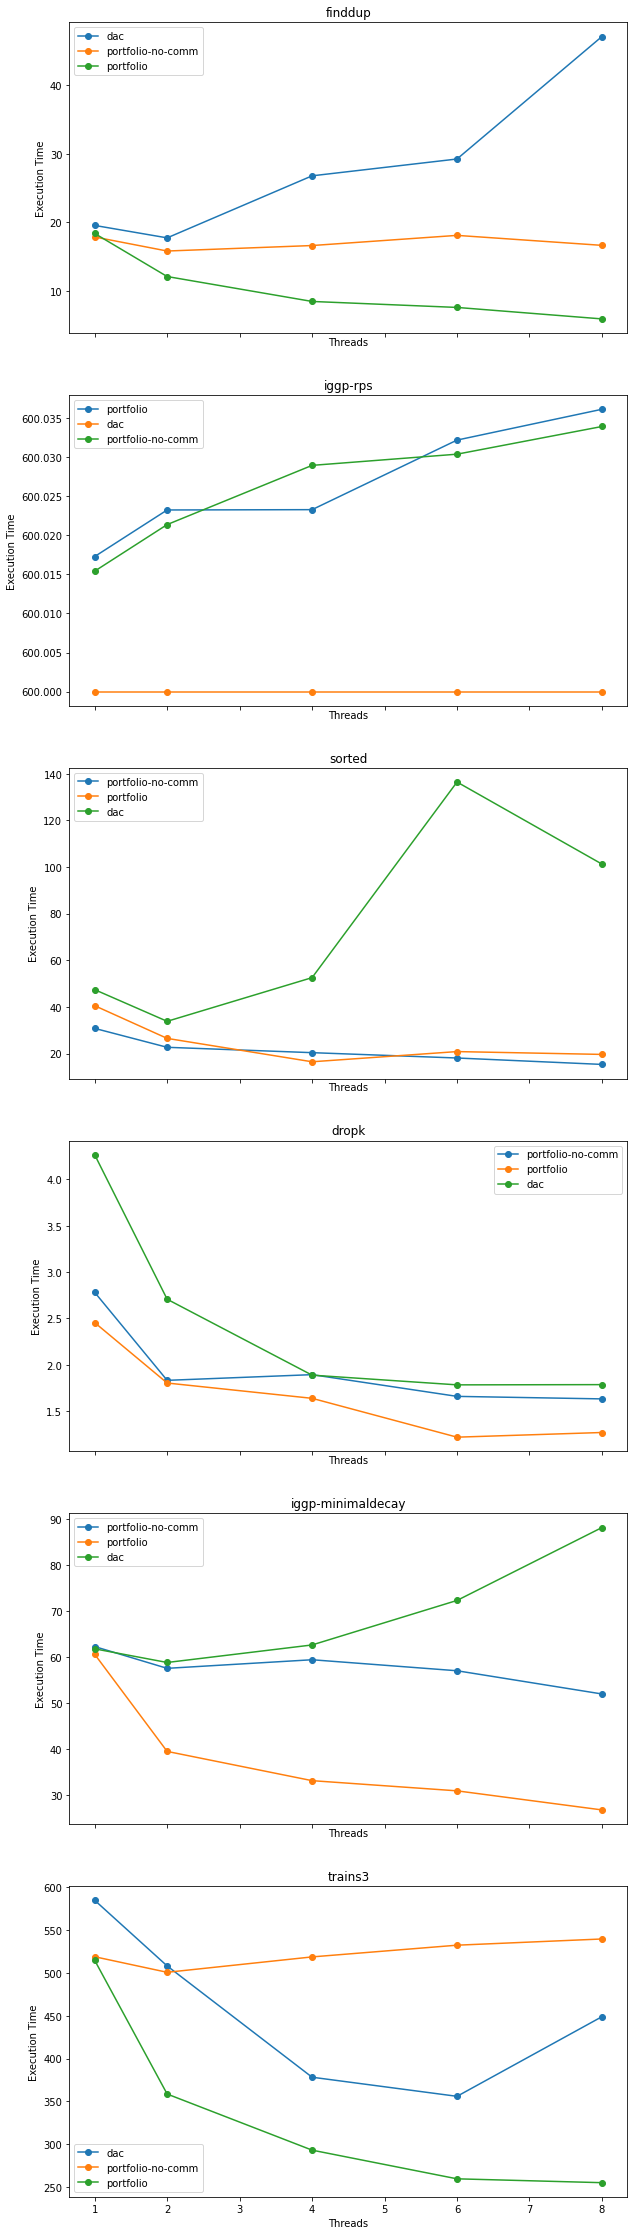

In [50]:
def draw_execution_time_line_chart(table_results):
    fig, axs = plt.subplots(len(table_results), figsize=(10, 40), sharex=True)
    for (i, (problem_name, problem_systems)) in enumerate(table_results.items()):
        system_pairs = {}
    
        for system, stats in problem_systems.items():
            _, name, threads = system.split("_")
            execution_time = stats["times"][0]
            system_pairs.setdefault(name, []).append((int(threads), execution_time))
        
        axs[i].set_title(problem_name)
        axs[i].set_xlabel("Threads")
        axs[i].set_ylabel("Execution Time")
        
        for system, pairs in system_pairs.items():
            if system in ['dac-no-comm', 'non-parallel']:
                continue
            elif system == 'non-parallel':
                time = pairs[0][1]
                x = [1, 2, 4, 6, 8]
                y = [time]*5
            else:
                sorted_pairs = sorted(pairs, key=lambda x: x[0])
                x = []
                y = []
                for threads, execution_time in sorted_pairs:
                    x.append(threads)
                    y.append(execution_time)
                #TODO Markers
            axs[i].plot(x, y, label=system, marker='o')
            
        axs[i].legend(loc="best")

draw_execution_time_line_chart(table_results)

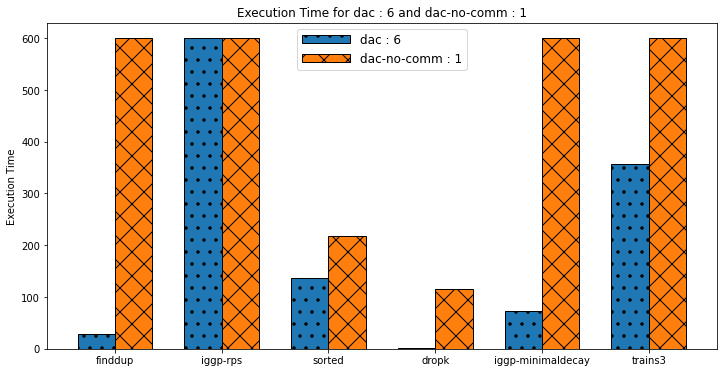

In [27]:
def draw_execution_time_bar_chart(table_results):
    # Create a fixed ordering of problems since they are stored in dicts and need to be transformed to lists
    problems = table_results.keys()
    labels = [PROBLEM_NAMES.get(name, name) for name in problems]

    # The chart only works with two systems so this example just arbitrarily takes the first two to extablish an order.
    systems = list(list(table_results.values())[0].keys())[0:2]
    system_names = [SYSTEM_NAMES.get(name, name) for name in systems]

    vals = []
    for system in systems:
        times = []
        vals.append(times)
        for problem in problems:
            system_summary = table_results[problem][system]
            # Append mean execution time
            times.append(system_summary[TIMES][0])

    grouped_bars(labels, 
            (vals[0], system_names[0]),
            (vals[1], system_names[1]),
            'Execution Time',
            f'Execution Time for {system_names[0]} and {system_names[1]}',
            '%.1f')

draw_execution_time_bar_chart(table_results)

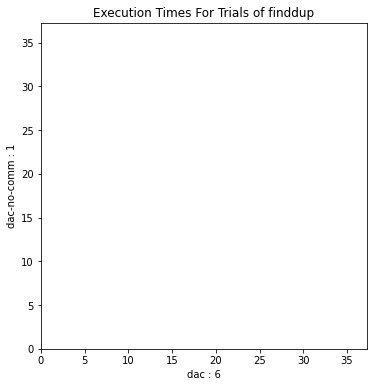

In [28]:
def draw_execution_time_scatter_plot(stitched_results):
    problem, problem_systems = list(stitched_results.items())[0]
    problem_name = PROBLEM_NAMES.get(problem, problem)

    systems = list(problem_systems.items())[0:2]
    system_names = [SYSTEM_NAMES.get(name, name) for (name, _) in systems]

    vals = []
    for (_, system) in systems:
        times = [trial.total_exec_time for trial in system]
        vals.append(times)

    scatter(vals[0], vals[1], system_names[0], system_names[1], f"Execution Times For Trials of {problem_name}")

draw_execution_time_scatter_plot(stitched_results)

## Popper Extra Stats
The `extra_stats` field on an `ExperimentResult` contains extra details about the execution of an instance. 

Currently this field is only populated by the Popper system.

Below are some example functions that show how the extra stats can be used for the current version of Popper.

In [ ]:
"""
    Returns a dict containing details of the last stage of execution for Popper. A stage is a search for a satisfying program with a certain number of literals.
    In this case, the last stage represents the search in which Popper either found a solution or identified that no solutions exist.
"""
def last_stage(result):
    stages = result.extra_stats["stages"]
    sorted_stages = sorted(stages, key=lambda x: x["num_literals"], reverse=True)
    return sorted_stages[0]

"""
    This function returns the number of literals in the solution (or the last number of literals Popper tried if there was no solution.)
"""
def num_literals(result):
    return last_stage(result)["num_literals"]

"""
    This function returns the total number of programs Popper tested before finding a solution or failing.
"""
def total_programs(result):
    return last_stage(result)["total_programs"]

"""
    This function returns the total duration of a given phase of the Popper loop.
"""
def duration(result, phase):
    return sum(result.extra_stats["durations"][phase])

In [ ]:
# This is an example of how the previous cell's functions can be used. It relies on there being a dropk problem for a system called "popper" with at least one trial.
# This may not be the case in all experiments, so it is meant for illustrative purposes.
popper_dropk_first_trial = stitched_results["dropk"]["popper"][0]

print(total_programs(popper_dropk_first_trial))
print(num_literals(popper_dropk_first_trial))
print(duration(popper_dropk_first_trial, "generate"))